# TP 1 - Diamants

Dataset (source : https://www.kaggle.com/datasets/shivam2503/diamonds):

* **price** : price in US dollars (\\$326-$18,823)
* **carat** : weight of the diamond (0.2-5.01)
* **cut** : quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* **color** : diamond colour, from J (worst) to D (best)
* **clarity** : a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* **x** : length in mm (0-10.74)
* **y** : width in mm (0-58.9)
* **z** : depth in mm (0-31.8)
* **depth** : total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43-79)
* **table** : width of top of diamond relative to widest point (43-95)

L'objectif est de prédire le prix d'un diamant à partir des informations que l'on a. Le notebook que l'on présente est une proposition de correction, mais n'est clairement pas la totalité de ce que l'on peut faire. Il y a de nombreux points que l'on peut améliorer, ce notebook a plus une portée pédagogique que de performance.

Commençons par importer les données :

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv("TP1 - Diamants.csv")
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


On remarque une colonne qui ne sert à rien, supprimons-la.

In [2]:
df = df.drop(columns=["Unnamed: 0"], axis=1)
df.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


## Qualité des données et exploration

Dans un premier temps, on veut s'assure que les données avec lesquelles nous allons travailler soient saine. On veut supprimer les données qui sortent *vraiment* du lot, et déterminer les variables qui auront une importance (ou non) dans la prédiction. Nous n'allons pas découper le dataset en train/test car nous allons seulement mettre en place une validation croisée. Nous travaillerons donc pour le travail de nettoyage sur l'ensemble du dataset.

On commence par les données numériques, puis par les données catégorielles.

### Données numériques

La méthode *describe* d'un DataFrame permet d'avoir une vision haut niveau de la répartition dans le dataset.

In [3]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Si on commence par regarder ce que l'on veut prédire, on note que la colonne *price* a une grande amplitude : de 326$ à 18823$. Sa moyenne est de l'ordre de 4000$, donc un bon modèle sera d'un ordre de grandeur inférieur. On note aussi un grand écarte de valeur entre le troisième quantile et le maximum : cela pourrait se traduire par une grande variance dans les performances du modèles en validation croisée. Si les valeurs extrêmes sont présentes dans un pli de test, on peut avoir des écarts de performances fort.

Il est étonnant que le minimum pour les variables *x*, *y* et *z* soit 0 : d'après le descriptif, cela voudrait dire que nous avons des diamants en une à deux dimension au lieu de 3. Extrayons les lignes concernées.

In [4]:
df.loc[(df["x"] == 0) | (df["y"] == 0) | (df["z"] == 0), ]

,carat,cut,color,clarity,depth,table,price,x,y,z
2207,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0
2314,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0
4791,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
5471,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
10167,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0
11182,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
11963,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.0
13601,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0
15951,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
24394,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.0


Nous allons supprimer ces données-là parce qu'elles n'ont pas de sens dans le contexte.

In [5]:
print("Taille avant : %d" % df.shape[0])
df = df.loc[(df["x"] > 0) & (df["y"] > 0) & (df["z"] > 0), ]
print("Taille après : %d" % df.shape[0])

Taille avant : 53940
Taille après : 53920


Vérifions à nouveau les statistiques du dataset :

In [6]:
df.describe()

,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Pour les variables *carat*, *y* et *z* on note un très grand écart entre le quantile à 75% et la valeur maximale. De plus, pour la variable *z*, on note un grand écart entre la valeur minimale et le quantile à 25% par rapport aux autres. Notons également la concentration de la variable *depth* avec 75% de ses valeurs comprisent entre 61 et 62.5 alors que son amplitude est de 36.

Pour le comprendre, nous nous proposons de constuire une fonction qui va visualiser :
1. La distribution d'une variable
2. La distribution de la variable d'intérêt *price* par rapport à la variable que l'on étudie.

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")



def explore_column(df, column, alpha=0.8, figsize=(15, 8)):
    
    def plot_histogram():
        plt.hist(df[column])
        plt.xlabel(column.capitalize())
        plt.title("Distribution de la variable %s" % column)
    
    def plot_price(alpha=alpha):
        plt.scatter(x=df[column], y=df["price"], alpha=alpha)
        plt.xlabel(column.capitalize())
        plt.ylabel("Price")
        plt.title("Price in function of %s" % column)
    
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1)
    plot_histogram()
    plt.subplot(1, 2, 2)
    plot_price()
    
    plt.suptitle("Variable %s" % column)
    plt.show()

Nous allons explorer chaque variable à l'aide de cette fonction. Commençons par la colonne *y* :

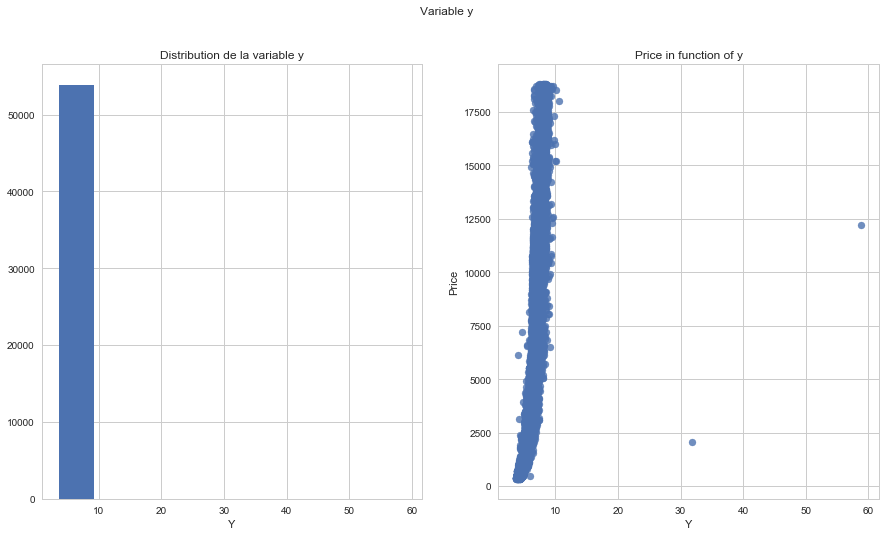

In [8]:
explore_column(df, "y")

On voit clairement que nous avons deux observations qui sont très éloignées du reste des observations. De plus, ces observations ne sont pas dans la *tendance* que l'on observe entre la variable *y* et la variable *price*. Nous devons donc supprimer ces deux observations car elles vont empêcher le modèle de bien apprendre.

In [9]:
print("Taille avant : %d" % df.shape[0])
df = df.loc[df["y"] < 30, ]
print("Taille après : %d" % df.shape[0])

Taille avant : 53920
Taille après : 53918


Visualisons à présent la même chose :

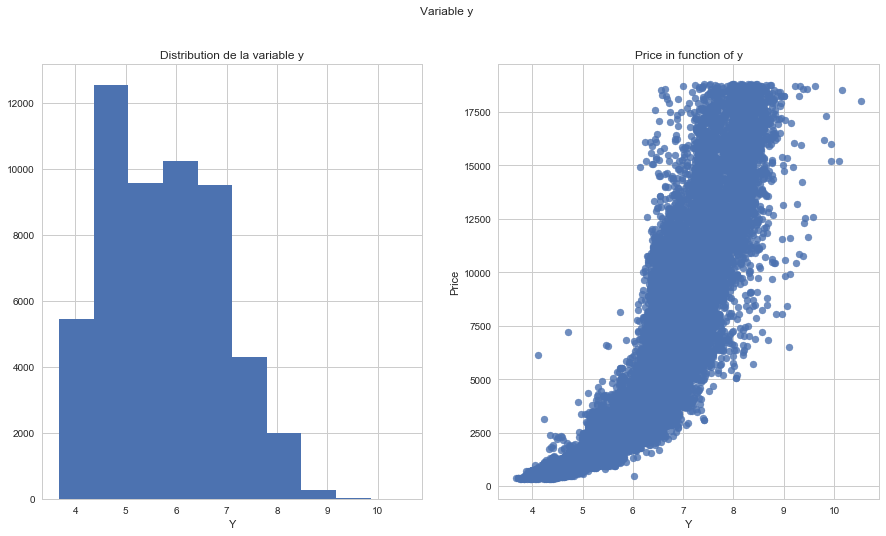

In [10]:
explore_column(df, "y")

On observe plutôt une tendance $x\mapsto x^2$ pour la relation entre *y* et *price*, et cette fois la distribution est beaucoup plus cohérente.
Nous ne présenterons pas la totalité des graphes, voici ce que l'on a observé pour les variables numériques :
* *z* : Des observations qui ne sont pas dans la tendance, à supprimer
* *carat* : Des observations sortent du lot, mais elles sont dans la tendance globale
* *depth* : On observe pas de tendance particulière avec la variable à prédire, probablement peu utile

Nettoyons.

In [11]:
print("Taille avant : %d" % df.shape[0])
df = df.loc[(df["z"] < 10) & (df["z"] > 2), ]
print("Taille après : %d" % df.shape[0])

Taille avant : 53918
Taille après : 53914


Notons qu'initialement, nous avions un dataset de 53940 lignes, donc nous n'avons que 26 observations en moins à présent.

### Données catégorielles

Pour étudier la distributions des données catégorielles, on se propose de visualiser des *violin plot* :

In [12]:
def make_violin_plot(column, figsize=(15, 8)):
    plt.figure(figsize=figsize)
    sns.violinplot(data=df, x="price", y=column, inner=None)
    plt.title("Distribution of price in function of %s" % column.capitalize())
    plt.show()

Commençons avec la colonne *clarity* :

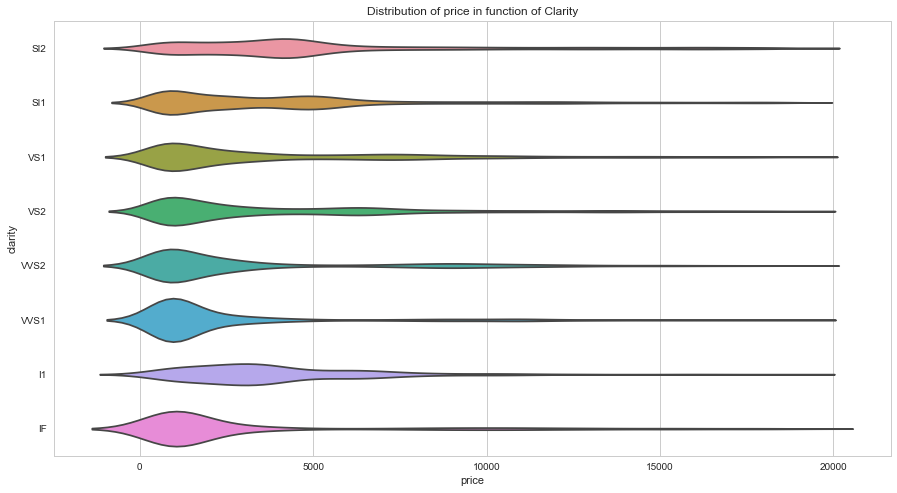

In [13]:
make_violin_plot("clarity")

On note que la valeur *SI2* et *I1* on des formes bien différentes du reste qui sont plus concentrées. A nouveau, nous ne présentons pas l'ensemble des graphiques. Dans l'ensemble, il n'y a pas de grandes tendances qui se dessinent.
Nous ne pouvons pas exploiter les données catégorielles directement : nous allons réaliser un *one hot encoding* pour pouvoir les utiliser dans notre régression linéaire.

In [14]:
df = pd.get_dummies(df, columns=["cut", "color", "clarity"])
df.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0


Nous avons maintenant 26 colonnes numériques que l'on peut exploiter.


## Modélisation

Nous avons maitenant un dataset nettoyé avec une première idées des éventuelles données qui seront utiles. Nous allons créer plusieurs modélisations et mesurer les performances. Pour se faciliter la tâche, nous allons construire une fonction pour le faire.

Cette fonction va réaliser une validation croisé puis afficher les performances. Notre métrique sera la RMSE en priorité, et nous exploiterons également le $R^2$ pour avoir un éclairage différent. 
Nous utiliserons donc la fonction *cross_val_score* pour réaliser la validation croisé. Pour avoir les performances que l'on souhaite, il faut que l'on utilise la fonction *make_scorer* pour avoir le bon format d'appel dans la fonction *cross_val_score*.

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


def train_predict(X, y, name, metric=mean_squared_error, cv=5):
    model = LinearRegression()
    scores = cross_val_score(model, X, y, scoring=make_scorer(metric), cv=cv)
    mean_scores = np.mean(scores)
    std_scores = np.std(scores)
    print("%s : %0.4f (+/- %0.4f)" % (name, mean_scores, std_scores))

Il nous reste à définir la RMSE et définir $X$ et $y$ :

In [16]:
RMSE = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

X = df.drop(columns=["price"], axis=1)
y = df["price"]

## Baseline

Nous avons réaliser un travail de nettoyage, essayons de mesurer l'apport de chaque partie. Autrement dit, quelles performances atteint-on si :

* On utilise la totalité du dataset initial (donc avec les valeurs extrêmes) mais uniquement les données numériques ?
* On utilise la totalité du dataset initial (donc avec les valeurs extrêmes) et aussi les données numériques ?
* On utilise le dataset sans les valeurs extrêmes mais uniquement les données numériques ?
* On utilise le dataset sans les valeurs extrêmes et aussi les données numériques ?

Pour se simplifier l'étude, on définit une fonction *preprocessing* qui reproduit les étapes que l'on a décrite tout au long du notebook.

In [17]:
def preprocessing(remove_outliers=True, get_categorical=True):
    df = pd.read_csv("TP1 - Diamants.csv")
    df = df.drop(columns=["Unnamed: 0"], axis=1)
    
    if remove_outliers:
        df = df.loc[(df["x"] > 0) & (df["y"] > 0) & (df["z"] > 0), ]
        df = df.loc[df["y"] < 30, ]
        df = df.loc[(df["z"] < 10) & (df["z"] > 2), ]
    
    if get_categorical:
        df = pd.get_dummies(df, columns=["cut", "color", "clarity"])
    else:
        df = df.drop(columns = ["cut", "color", "clarity"])
    
    y = df["price"]
    X = df.drop(columns = ["price"], axis=1)
    return X, y  

Commençons les comparaisons :

In [18]:
X, y = preprocessing(remove_outliers=False, get_categorical=False)
train_predict(X, y, "Avec outlier, sans variables catégorielles", metric=RMSE, cv=10)

X, y = preprocessing(remove_outliers=False, get_categorical=True)
train_predict(X, y, "Avec outlier, avec variables catégorielles", metric=RMSE, cv=10)

X, y = preprocessing(remove_outliers=True, get_categorical=False)
train_predict(X, y, "Sans outlier, sans variables catégorielles", metric=RMSE, cv=10)

X, y = preprocessing(remove_outliers=True, get_categorical=True)
train_predict(X, y, "Sans outlier, avec variables catégorielles", metric=RMSE, cv=10)

Avec outlier, sans variables catégorielles : 1352.2158 (+/- 874.1716)
Avec outlier, avec variables catégorielles : 1123.4663 (+/- 579.5805)
Sans outlier, sans variables catégorielles : 1340.0384 (+/- 865.8810)
Sans outlier, avec variables catégorielles : 1113.9559 (+/- 578.7700)


On note un gain net de l'utilisation des variables catégorielles : en RMSE moyenne et en réduction de variance. On note également une baisse sensible de la RMSE grâce au travail sur les données extrêmes.

### Améliorations

On note également que la variance semble forte. C'est cohérent avec la distribution que l'on a observé au début sur la distribution de la variable *price*. Une solution sera de régulariser le modèle en réalisant une régression Ridge ou Lasso par exemple. 
Avant de changer d'algorithme, on veut essayer de tirer profit des remarques que l'on a fait pendant la partie d'exploration des données.

Nous avions noté que la variable $y$ était *lié* au prix avec une tendance de la forme $x\mapsto x^2$. Essayons d'ajouter $y^2$ et mesurons la performance.

In [20]:
X, y = preprocessing(remove_outliers=True, get_categorical=True)
X["y2"] = X["y"] ** 2
train_predict(X, y, "Ajout d'y^2", metric=RMSE, cv=10)

Ajout d'y^2 : 1075.4688 (+/- 563.2024)


C'est un peu mieux ! Nous avons noté la même tendance avec la variable $x$. De plus nous avions trouvé que la colonne *depth* n'était pas utile. Essayons également, et entraînons un nouveau modèle :

In [21]:
X, y = preprocessing(remove_outliers=True, get_categorical=True)
X["x^2"] = X["x"]**2
X["y^2"] = X["y"]**2
X = X.drop(columns=["depth"], axis=1)
train_predict(X, y, "Exploration des données", metric=RMSE, cv=10)

Exploration des données : 1064.3384 (+/- 558.8947)


Nous avons bien réduit à nouveau à la fois la RMSE et la variance. Testons à présent la pénalisation pour réduire la variance.

### Régression Ridge

Nous ne travaillerons qu'avec la régression Ridge car l'intérêt de sélection des variables de la méthode LASSO n'est pas primordiale ici : nous avons *peu* d'informations au regard du nombre d'observations. Cela reste tout de même un exercice que l'on peut réaliser pour s'en convaincre.

Nous allons entraîner un ensemble de régression Ridge avec à chaque fois une valeur de pénalisation différente pour identifier la meilleure valeur de $\lambda$.

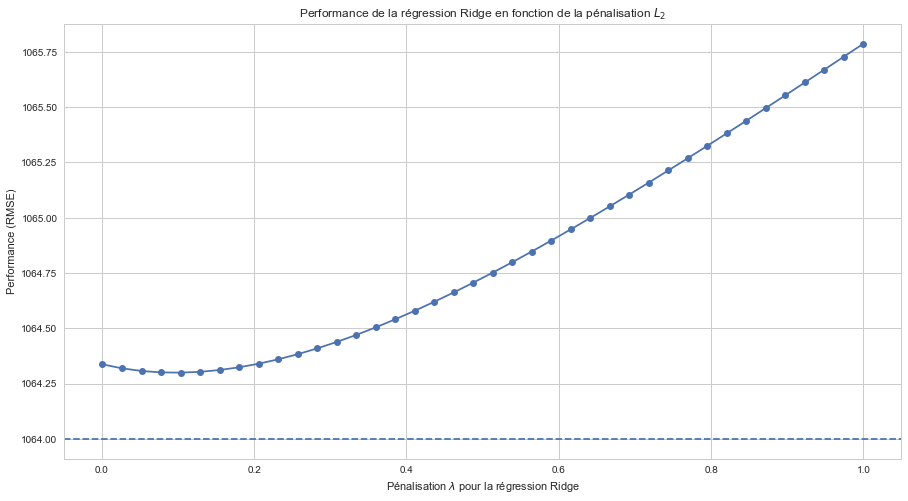

In [22]:
from sklearn.linear_model import Ridge

alpha_grid = np.linspace(0.001, 1, 40)
score_result = []
for alpha in alpha_grid:
    model = Ridge(alpha=alpha)
    scores = cross_val_score(model, X, y, scoring=make_scorer(RMSE), cv=10)
    score_result.append(scores.mean())


plt.figure(figsize=(15, 8))
plt.plot(alpha_grid, score_result, 'o-')
plt.axhline(y=1064, ls='--')
plt.xlabel(r"Pénalisation $\lambda$ pour la régression Ridge")
plt.ylabel("Performance (RMSE)")
plt.title(r"Performance de la régression Ridge en fonction de la pénalisation $L_2$")
plt.show()

On a tracé en pointillé la valeur obtenue par la régression Ridge : on obtient pas une meilleure valeur en RMSE. Vérifions si on obtient une variance réduite pour le meilleure $\lambda$ qui semble être 0.1

In [23]:
model = Ridge(alpha=0.1)
scores = cross_val_score(model, X, y, scoring=make_scorer(RMSE), cv=10)
mean_scores = np.mean(scores)
std_scores = np.std(scores)
print("%s : %0.4f (+/- %0.4f)" % ("Ridge", mean_scores, std_scores))

Ridge : 1064.2999 (+/- 559.2911)


On obtient sensiblement le même modèle. Il est donc très probable que l'on ait atteint les limites d'une modélisation raisonnable du prix d'un diamant par une méthode linéaire. Il nous faudra probablement une meilleure approche pour avoir une meilleure RMSE.


## Etude des résultats

On souhaite avoir une meilleure *compréhension* de notre modèle. Le meilleur que nous ayons construit est entraîné à partir de données traités et augmenté. Entraînons-le sur un dataset de test et mesurons ses performances sur un jeu de test.

In [24]:
from sklearn.model_selection import train_test_split

X, y = preprocessing(remove_outliers=True, get_categorical=True)
X["x^2"] = X["x"]**2
X["y^2"] = X["y"]**2
X = X.drop(columns=["depth"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE : %0.4f" % RMSE(y_test, y_pred))

RMSE : 1063.6756


C'est un peu inférieur à la moyenne, mais c'est dans l'intervalle de confiance. Visualisons les distributions de y_test et y_pred :

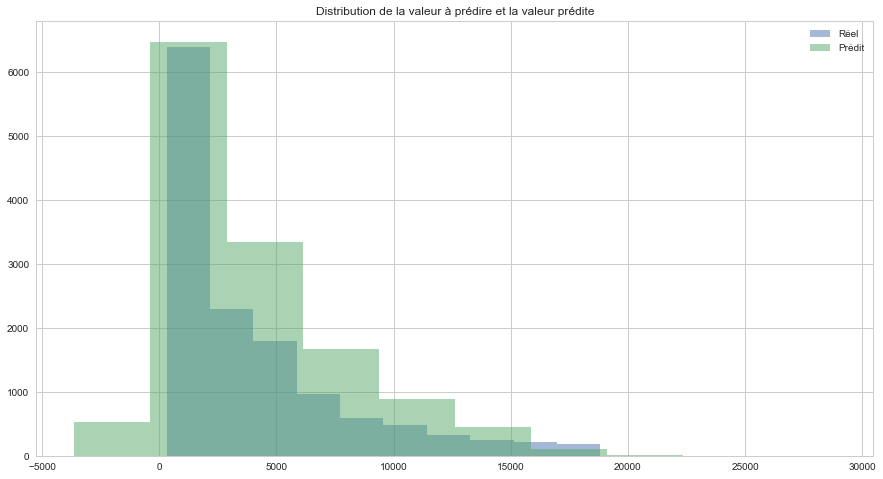

In [25]:
plt.figure(figsize=(15, 8))
plt.hist(y_test, color=sns.color_palette()[0], label="Réel", alpha=0.5)
plt.hist(y_pred, color=sns.color_palette()[1], label="Prédit", alpha=0.5)
plt.legend()
plt.title("Distribution de la valeur à prédire et la valeur prédite")
plt.show()

C'est la même dynamique à ceci près que des valeurs négatives sont prédites par le modèle ! A part modifier notre approche, on ne peut pas vraiment contrôler cela. Essayons d'observer s'il existe une tendance de qualité de prédiction du modèle selon les prix:

In [26]:
thresholds = np.linspace(min(y_test), max(y_test), 10)

for min_threshold, max_threshold in zip(thresholds[:-1], thresholds[1:]):
    y_interval = y_test[(min_threshold <= y_test) & (y_test <= max_threshold)]
    y_pred_interval = y_pred[(min_threshold <= y_test) & (y_test <= max_threshold)]
    performance = RMSE(y_interval, y_pred_interval)
    print("[%0.2f, %0.2f] : %0.4f pour %d observations" % (min_threshold, max_threshold, performance, len(y_interval)))

[326.00, 2380.67] : 656.7288 pour 6725 observations
[2380.67, 4435.33] : 669.2420 pour 2458 observations
[4435.33, 6490.00] : 813.7800 pour 1658 observations
[6490.00, 8544.67] : 1228.9875 pour 863 observations
[8544.67, 10599.33] : 1527.6036 pour 604 observations
[10599.33, 12654.00] : 1783.1422 pour 432 observations
[12654.00, 14708.67] : 2287.1997 pour 289 observations
[14708.67, 16763.33] : 2801.5625 pour 243 observations
[16763.33, 18818.00] : 3566.9308 pour 208 observations


Nous venons de contextualiser la performance de prédiction selon les tranches de prix à prédire.
Le modèle semble meilleur pour prédire les diamants les plus chers. Si on découpe par rapport à la valeur prédite cette fois :

In [27]:
thresholds = np.linspace(min(y_pred), max(y_pred), 10)

for min_threshold, max_threshold in zip(thresholds[:-1], thresholds[1:]):
    y_interval = y_test[(min_threshold <= y_pred) & (y_pred <= max_threshold)]
    y_pred_interval = y_pred[(min_threshold <= y_pred) & (y_pred <= max_threshold)]
    performance = RMSE(y_interval, y_pred_interval)
    print("[%0.2f, %0.2f] : %0.4f pour %d observations" % (min_threshold, max_threshold, performance, len(y_interval)))

[-3617.61, -10.20] : 1390.0745 pour 852 observations
[-10.20, 3597.20] : 470.9755 pour 6994 observations
[3597.20, 7204.61] : 807.5681 pour 3337 observations
[7204.61, 10812.01] : 1770.2651 pour 1301 observations
[10812.01, 14419.42] : 2392.6633 pour 688 observations
[14419.42, 18026.82] : 2072.0490 pour 273 observations
[18026.82, 21634.23] : 3656.2618 pour 29 observations
[21634.23, 25241.63] : 5361.0926 pour 4 observations
[25241.63, 28849.04] : 13626.0356 pour 1 observations


On retrouve la même conclusion, le modèle semble plus performant avec des prix plus élevé. On aura donc plus confiance dans la prédiction de ce modèle quand la prédiction sera élevée !